# KTR Example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import matplotlib
import matplotlib.pyplot as plt

import orbit
from orbit.models import KTRLite, KTR

from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.metrics import smape
from orbit.utils.dataset import load_iclaims, load_electricity_demand

In [3]:
orbit.__version__

'1.1.0dev'

## Data

In [38]:
df = load_iclaims()

DATE_COL = 'week'
RESPONSE_COL = 'claims'

print(df.shape)

df.head()

(443, 7)


,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.38660,0.21988,-0.31845,0.11750,-0.41763,0.12265
1,2010-01-10,13.62422,0.21988,-0.19484,0.16879,-0.42548,0.11044
2,2010-01-17,13.39874,0.23614,-0.29248,0.11750,-0.46523,0.53234
3,2010-01-24,13.13755,0.20335,-0.19484,0.10692,-0.48175,0.42864
4,2010-01-31,13.19676,0.13436,-0.24247,0.07448,-0.48893,0.48740


In [39]:
print(f'starts with {df[DATE_COL].min()}\nends with {df[DATE_COL].max()}\nshape: {df.shape}')

starts with 2010-01-03 00:00:00
ends with 2018-06-24 00:00:00
shape: (443, 7)


In [40]:
test_size = 52

train_df = df[:-test_size]
test_df = df[-test_size:]

## KTR

### KTR - Full

### default zero regression_segments

In [74]:
ktr = KTR(
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
#     regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
        regressor_col=['trend.unemploy'],
    seasonality=[52],
    seasonality_fs_order=[3],
    level_knot_scale=.1,
    level_segments=10,
    regression_segments=0,
    regression_rho=0.15,
    # pyro optimization parameters
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    estimator='pyro-svi',
    n_bootstrap_draws=-1,
    ktrlite_optim_args = dict()
)

In [75]:
ktr.fit(train_df)

INFO:root:Guessed max_plate_nesting = 1


In [76]:
coef_df = ktr.get_regression_coefs()
coef_df

,week,trend.unemploy
0,2010-01-03,0.09429
1,2010-01-10,0.09429
2,2010-01-17,0.09429
3,2010-01-24,0.09429
4,2010-01-31,0.09429
...,...,...
386,2017-05-28,0.09429
387,2017-06-04,0.09429
388,2017-06-11,0.09429
389,2017-06-18,0.09429


In [77]:
knot_df = ktr.get_regression_coef_knots()
knot_df

,week,step,trend.unemploy
0,2010-01-03,0,0.09429


In [78]:
ktr.get_regression_coefs().head()

,week,trend.unemploy
0,2010-01-03,0.09429
1,2010-01-10,0.09429
2,2010-01-17,0.09429
3,2010-01-24,0.09429
4,2010-01-31,0.09429


In [79]:
ktr.get_regression_coef_knots()

,week,step,trend.unemploy
0,2010-01-03,0,0.09429


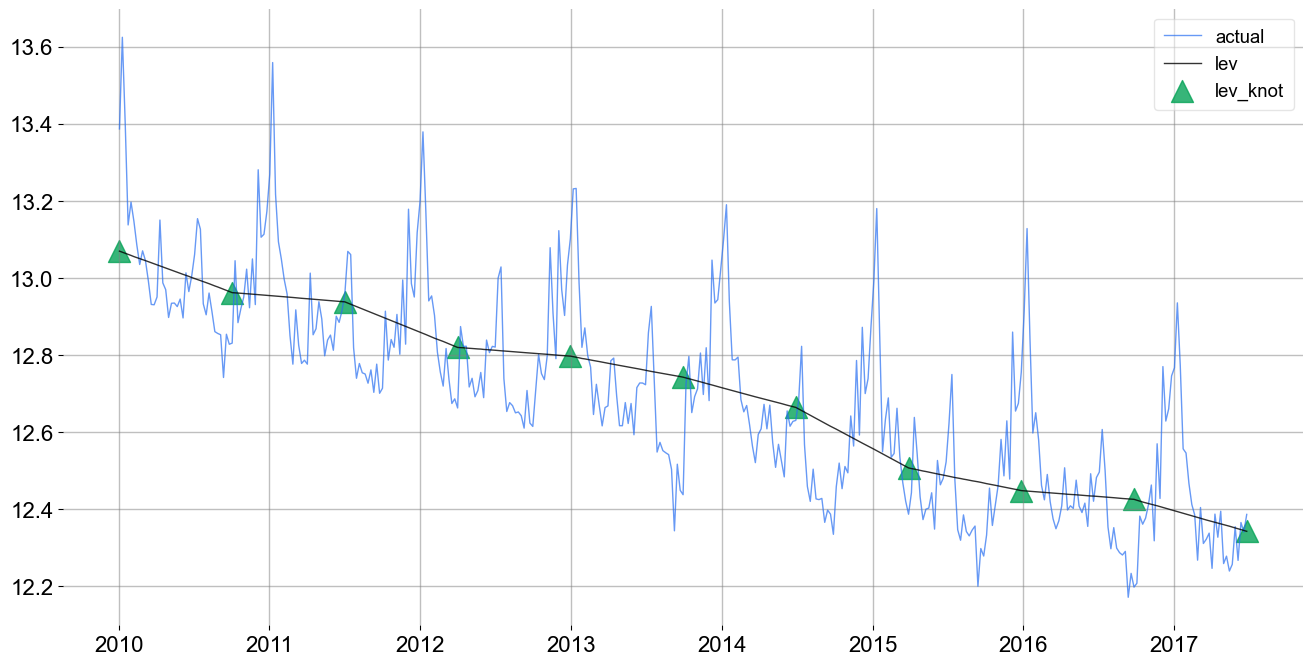

In [80]:
ktr.plot_lev_knots(figsize=(16, 8));

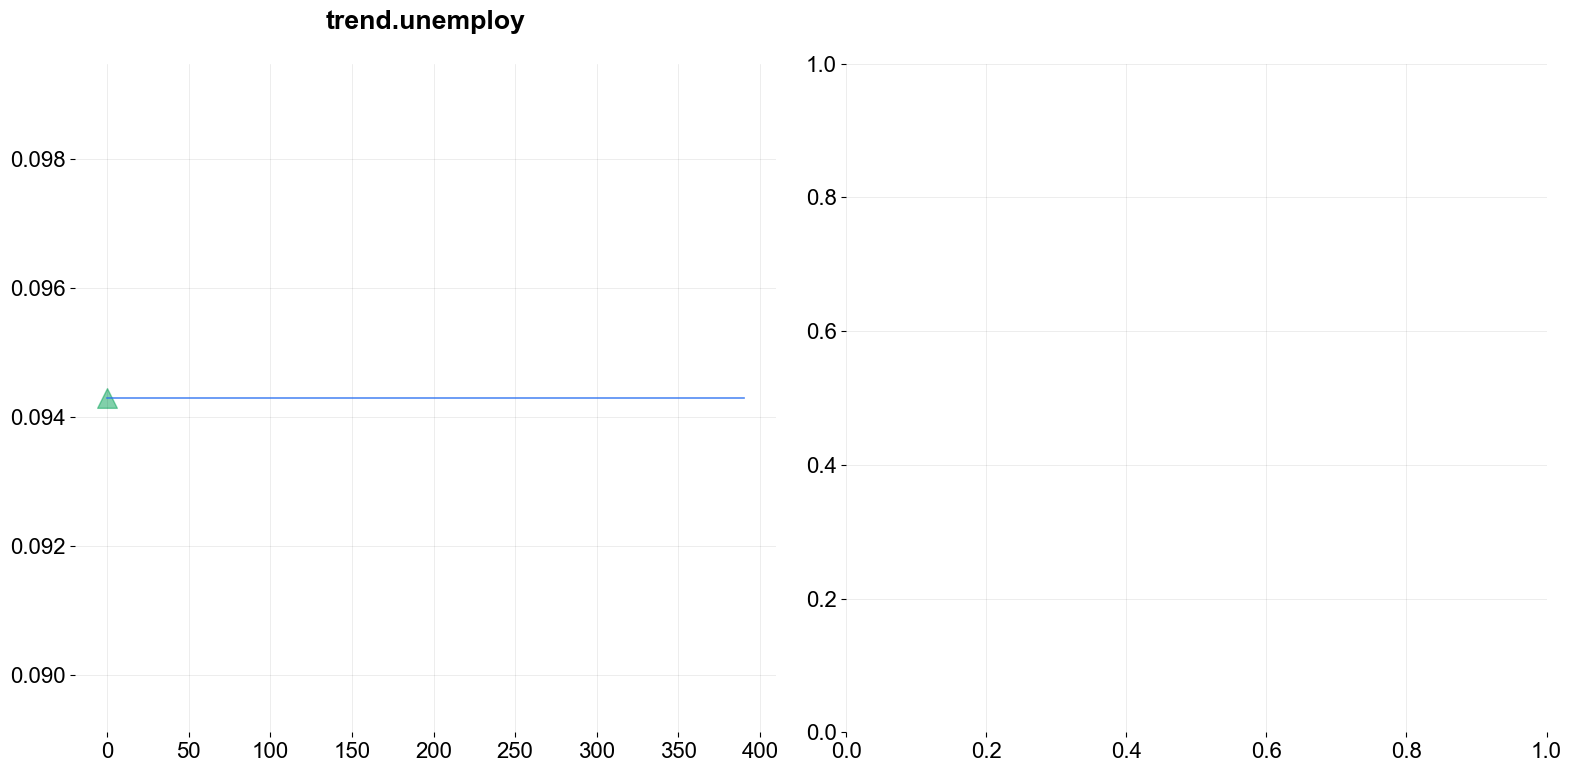

In [81]:
ktr.plot_regression_coefs(with_knot=True, include_ci=False, figsize=(16, 8));

In [82]:
predicted_df = ktr.predict(df=test_df, decompose=True)
predicted_df.head()

,week,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,regression_5,regression,regression_95,seasonality_52_5,seasonality_52,seasonality_52_95
0,2017-07-02,12.18142,12.34380,12.50917,12.17414,12.33618,12.50183,0.01286,0.02073,0.02854,-0.01455,-0.01455,-0.01455
1,2017-07-09,12.18960,12.34725,12.50116,12.19238,12.34679,12.50390,0.01475,0.02378,0.03273,-0.02259,-0.02259,-0.02259
2,2017-07-16,12.16265,12.32094,12.49028,12.18200,12.33801,12.50704,0.01091,0.01759,0.02421,-0.03450,-0.03450,-0.03450
3,2017-07-23,12.14554,12.30865,12.46087,12.17824,12.34259,12.49366,0.00991,0.01598,0.02199,-0.05014,-0.05014,-0.05014
4,2017-07-30,12.12721,12.28525,12.44397,12.17670,12.33711,12.49577,0.01091,0.01759,0.02421,-0.06903,-0.06903,-0.06903


In [83]:
f"SMAPE: {smape(predicted_df['prediction'].values, test_df[RESPONSE_COL].values):.2%}"

'SMAPE: 0.72%'

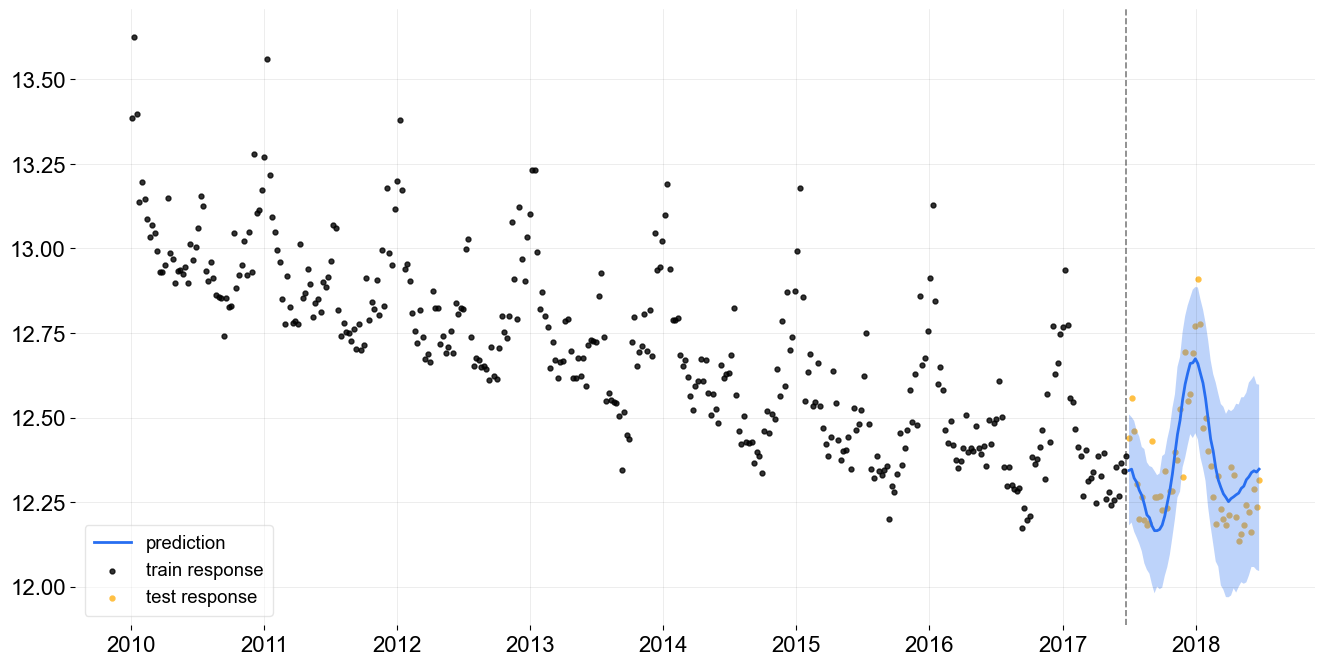

In [84]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df)

### multiple regression_segments

Change `regression_segments=0` args to `regression_segments=5`.

In [85]:
ktr = KTR(
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    seasonality=[52],
    seasonality_fs_order=[3],
    level_knot_scale=.1,
    level_segments=10,
    regression_segments=5,
    regression_rho=0.15,
    # pyro optimization parameters
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    estimator='pyro-svi',
    n_bootstrap_draws=-1,
    ktrlite_optim_args = dict()
)

In [86]:
ktr.fit(train_df)

INFO:root:Guessed max_plate_nesting = 1


In [87]:
ktr.get_regression_coefs().head()

,week,trend.unemploy,trend.filling,trend.job
0,2010-01-03,0.12436,0.09211,0.18980
1,2010-01-10,0.12427,0.09228,0.18999
2,2010-01-17,0.12417,0.09245,0.19018
3,2010-01-24,0.12408,0.09262,0.19037
4,2010-01-31,0.12398,0.09279,0.19056


In [88]:
ktr.get_regression_coef_knots()

,week,step,trend.unemploy,trend.filling,trend.job
0,2010-01-03,0,0.12964,0.08219,0.17732
1,2011-07-03,78,0.11302,0.11447,0.22124
2,2012-12-30,156,0.10470,0.11517,0.17264
3,2014-06-29,234,0.05415,0.12498,0.15725
4,2015-12-27,312,0.09445,0.07963,0.16472
5,2017-06-25,390,0.13183,0.09007,0.15337


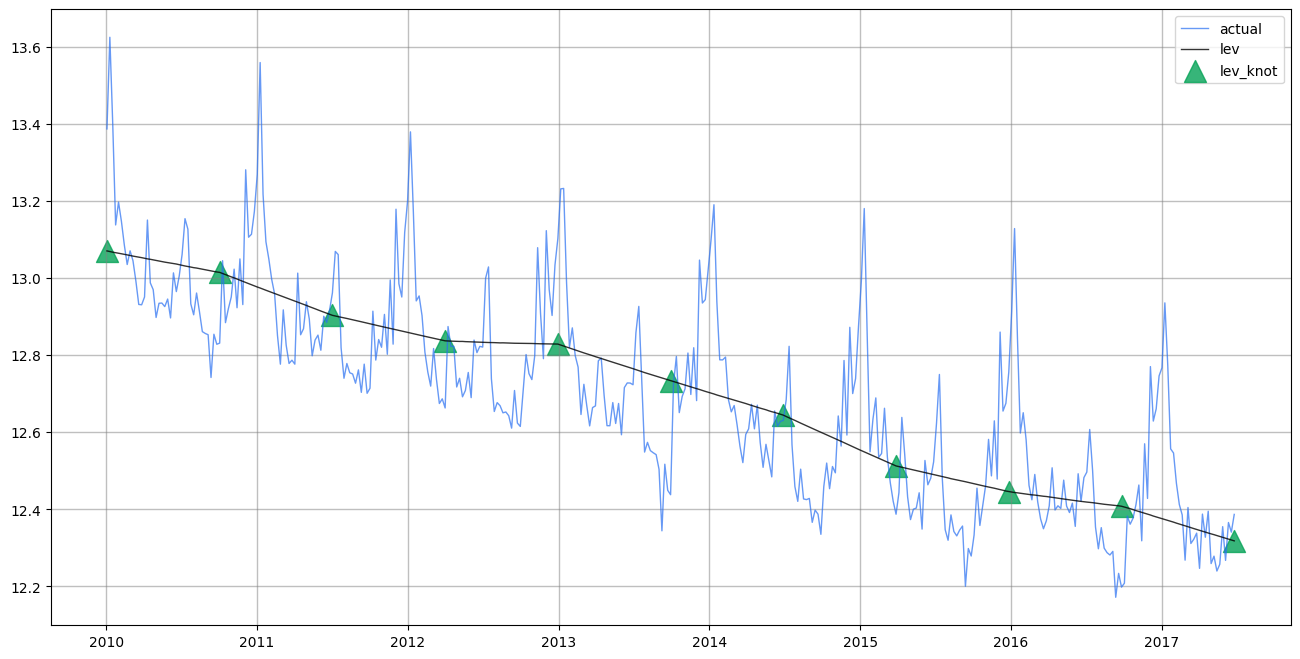

In [89]:
ktr.plot_lev_knots(figsize=(16, 8), use_orbit_style=False);

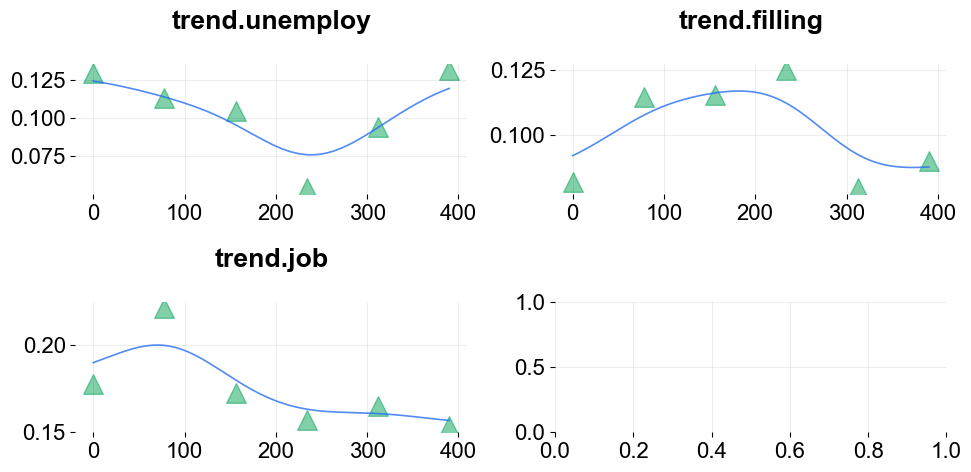

In [90]:
ktr.plot_regression_coefs(with_knot=True, figsize=(10, 5), include_ci=False);

In [91]:
predicted_df = ktr.predict(df=test_df, decompose=True)
predicted_df.head()

,week,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,regression_5,regression,regression_95,seasonality_52_5,seasonality_52,seasonality_52_95
0,2017-07-02,12.16517,12.32254,12.47812,12.15440,12.31603,12.47200,-0.00799,0.02339,0.05281,-0.01455,-0.01455,-0.01455
1,2017-07-09,12.17748,12.33844,12.49418,12.16617,12.32580,12.48115,0.00752,0.03829,0.06552,-0.02259,-0.02259,-0.02259
2,2017-07-16,12.15415,12.30563,12.47224,12.15734,12.31207,12.47958,0.00381,0.02776,0.05034,-0.03450,-0.03450,-0.03450
3,2017-07-23,12.13769,12.29724,12.44987,12.15560,12.31675,12.46906,0.00764,0.02799,0.04738,-0.05014,-0.05014,-0.05014
4,2017-07-30,12.12600,12.27863,12.44312,12.15718,12.31120,12.47586,0.01213,0.03506,0.05938,-0.06903,-0.06903,-0.06903


In [23]:
f"SMAPE: {smape(predicted_df['prediction'].values, test_df[RESPONSE_COL].values):.2%}"

'SMAPE: 0.73%'

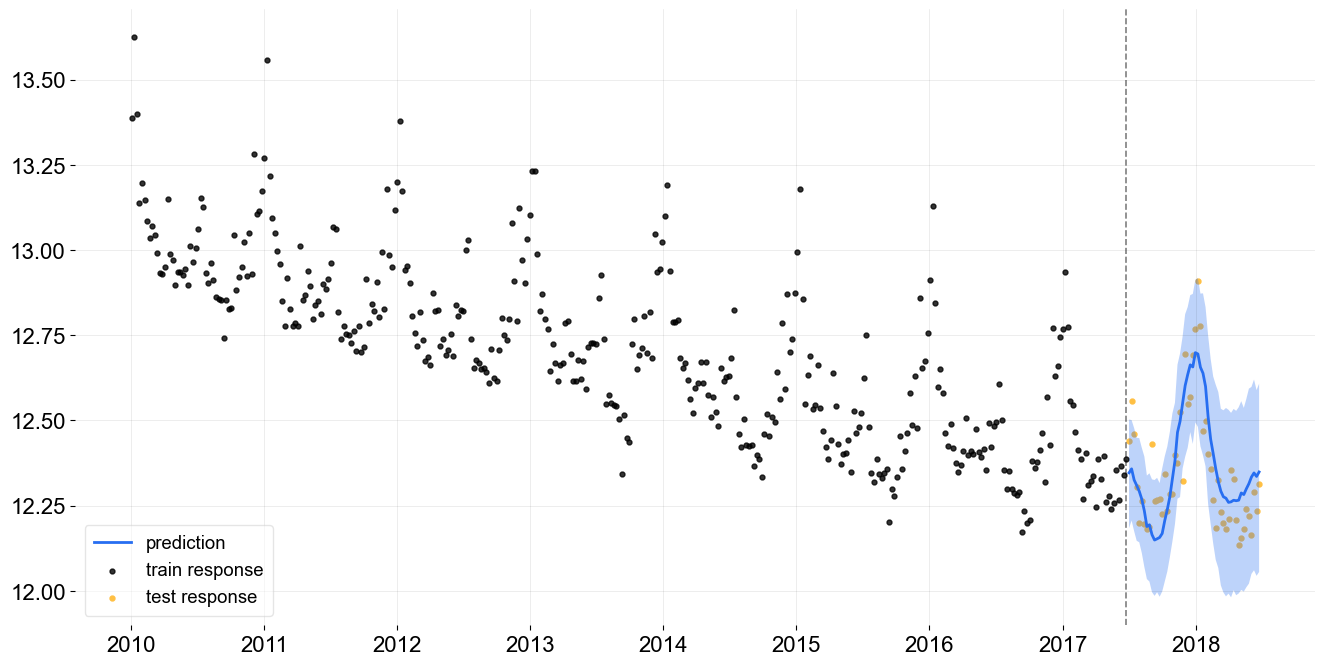

In [24]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df)

In [92]:
knot_df = ktr.get_regression_coef_knots()
knot_df

,week,step,trend.unemploy,trend.filling,trend.job
0,2010-01-03,0,0.12964,0.08219,0.17732
1,2011-07-03,78,0.11302,0.11447,0.22124
2,2012-12-30,156,0.10470,0.11517,0.17264
3,2014-06-29,234,0.05415,0.12498,0.15725
4,2015-12-27,312,0.09445,0.07963,0.16472
5,2017-06-25,390,0.13183,0.09007,0.15337


### KTR - Median

INFO:root:Guessed max_plate_nesting = 1


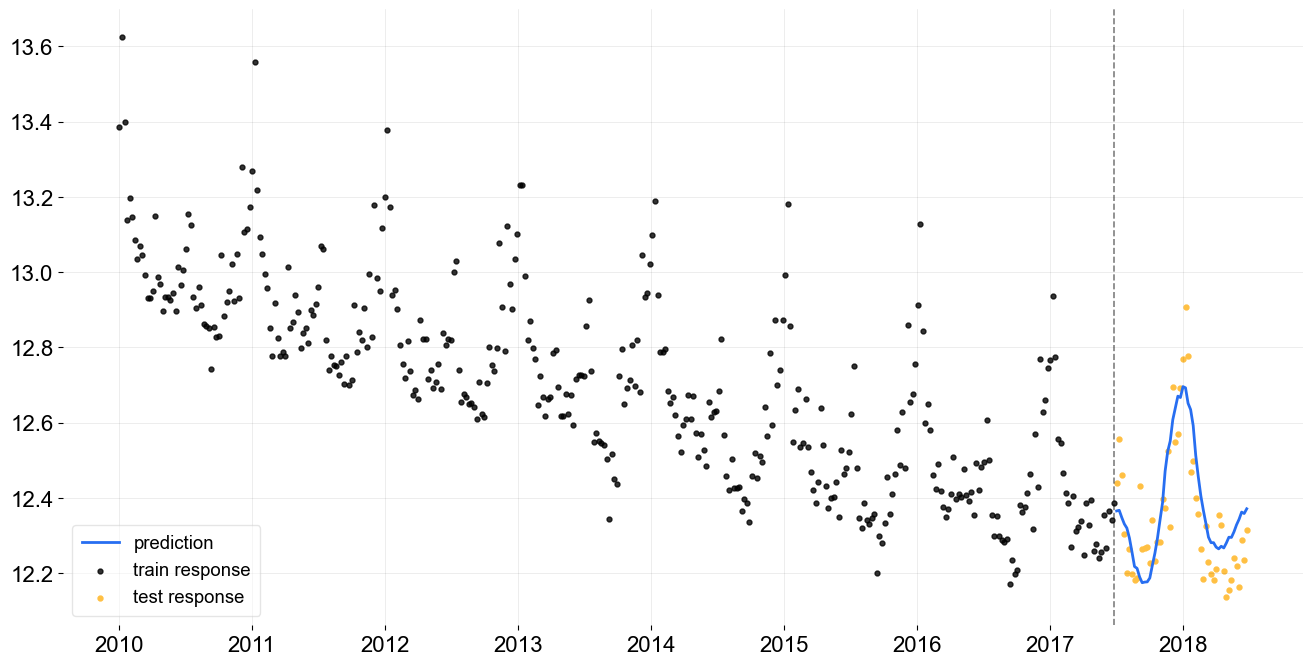

In [25]:
ktr = KTR(
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    seasonality=[52],
    seasonality_fs_order=[3],
    level_knot_scale=.1,
    level_segments=10,
    seasonality_segments=2,
    regression_segments=5,
    regression_rho=0.15,
    # pyro optimization parameters
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    estimator='pyro-svi',
    n_bootstrap_draws=-1
)

ktr.fit(df=train_df, point_method='median')
ktr.get_regression_coefs().head()

predicted_df = ktr.predict(df=test_df, decompose=True)
predicted_df.tail()

f"SMAPE: {smape(predicted_df['prediction'].values, test_df[RESPONSE_COL].values):.2%}"

_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df)

## Electricity data (dual seasoanlity, no regressor)

In [26]:
# from 2000-01-01 to 2008-12-31
df = load_electricity_demand()

df['electricity'] = np.log(df['electricity'])

DATE_COL = 'date'
RESPONSE_COL = 'electricity'

print(df.shape)
df.head()

(3288, 2)


,date,electricity
0,2000-01-01,9.43760
1,2000-01-02,9.50130
2,2000-01-03,9.63565
3,2000-01-04,9.65392
4,2000-01-05,9.66089


In [27]:
test_size = 365

train_df = df[:-test_size]
test_df = df[-test_size:]

In [28]:
ktr = KTR(
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 5],
    level_knot_scale=.1,
    level_segments=20,
    seasonality_segments=3,
    regression_segments=5,
    regression_rho=0.15,
    # pyro optimization parameters
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    estimator='pyro-svi',
    n_bootstrap_draws=-1
)

In [29]:
ktr.fit(df=train_df, point_method='median')

INFO:root:Guessed max_plate_nesting = 1


In [30]:
predicted_df = ktr.predict(df=test_df, decompose=True)
predicted_df.tail()

,date,prediction,trend,regression,seasonality_7,seasonality_365.25
360,2008-12-27,9.94797,9.98654,0.00000,-0.03038,-0.00819
361,2008-12-28,9.89279,9.98654,0.00000,-0.08448,-0.00928
362,2008-12-29,9.95740,9.98654,0.00000,-0.01905,-0.01009
363,2008-12-30,10.01911,9.98654,0.00000,0.04319,-0.01062
364,2008-12-31,10.00047,9.98654,0.00000,0.02480,-0.01087


In [31]:
f"SMAPE: {smape(predicted_df['prediction'].values, test_df[RESPONSE_COL].values):.2%}"

'SMAPE: 0.54%'

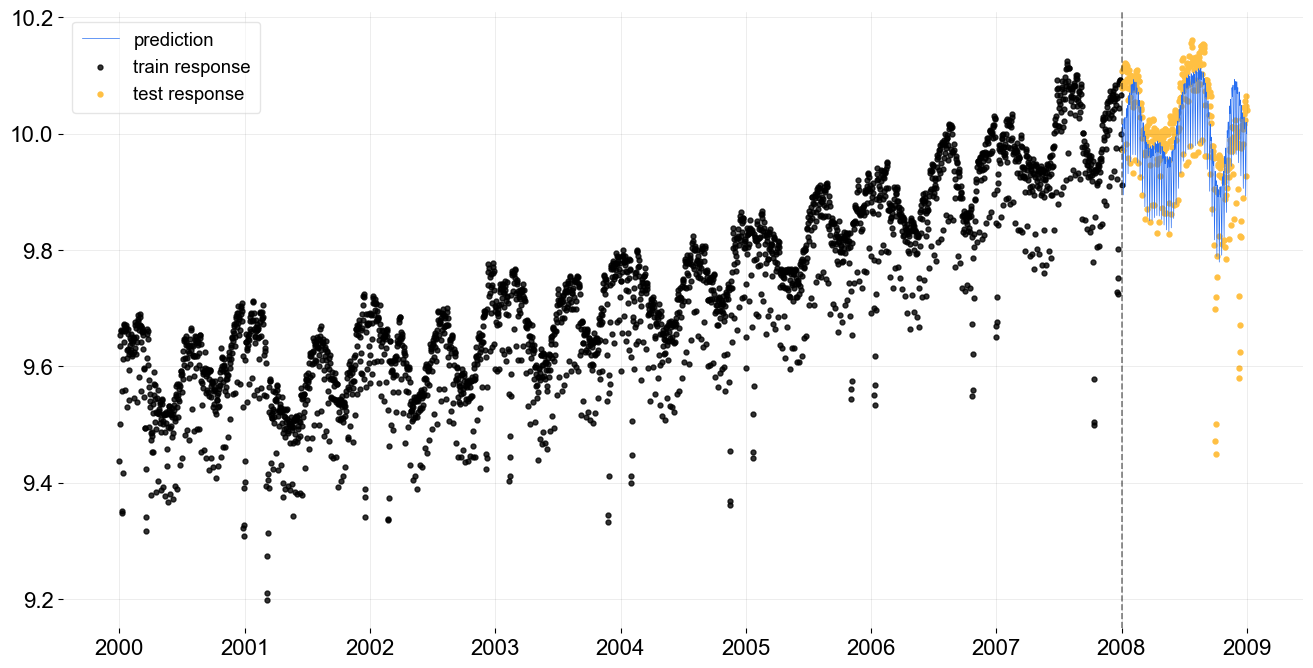

In [32]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df,
                       lw=0.5)